# APC CAS_KAGGLE ALCOHOL

* JAN PLANAS BATLLORI
* NIU: 1636492

### Student Alcohol Consumption

[Kaggle Dataset](https://www.kaggle.com/datasets/uciml/student-alcohol-consumption/data)

En aquest ficher resoldre un problema de classificació el qual haurè de predir les notes de matemàtiques i de portugues dels alumnes. 

#### INCLUDES

In [3]:
import numpy as np
import pandas as pd
import time
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.metrics import accuracy_score,  precision_score, recall_score, roc_curve, roc_auc_score, auc, f1_score, balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve, classification_report, mean_squared_error, r2_score

from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder

from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA


from imblearn.over_sampling import RandomOverSampler, SMOTE

import warnings
warnings.filterwarnings("ignore")

### EDA

In [2]:
math_data = pd.read_csv("student-mat.csv")
por_data = pd.read_csv("student-por.csv")

df = pd.concat([math_data, por_data], ignore_index=True)
#df = pd.read_csv("student-mat.csv")
df.info()
print(f"El shape del train-data es {df.shape}.")
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   int64 
 3   address     1044 non-null   object
 4   famsize     1044 non-null   object
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   int64 
 7   Fedu        1044 non-null   int64 
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   int64 
 13  studytime   1044 non-null   int64 
 14  failures    1044 non-null   int64 
 15  schoolsup   1044 non-null   object
 16  famsup      1044 non-null   object
 17  paid        1044 non-null   object
 18  activities  1044 non-null   object
 19  nursery     1044 non-null   object
 20  higher  

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [3]:
print(df.isna().sum().sum())

0


Farem un primer anàlisi dels atribut que tenim i els calssificarem en categòrics i numèrics.  

In [4]:
categorics = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
numerics = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
targets = ['G1', 'G2', 'G3']


Balanceig numerics.

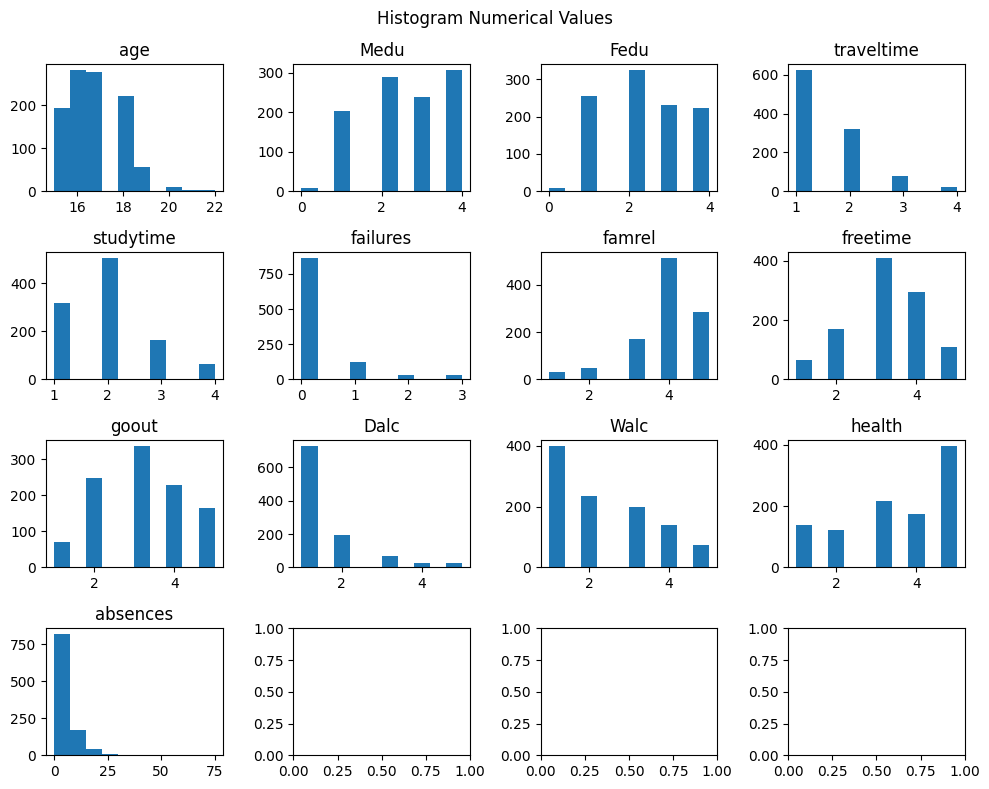

In [5]:
df_num = df[numerics]
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 8))
fig.suptitle('Histogram Numerical Values')

for i, ax in zip(df_num.columns, axes.ravel()):
    ax.hist(df_num[i], bins=10)
    ax.set_title(i)

plt.tight_layout()

Balanceig categorics.

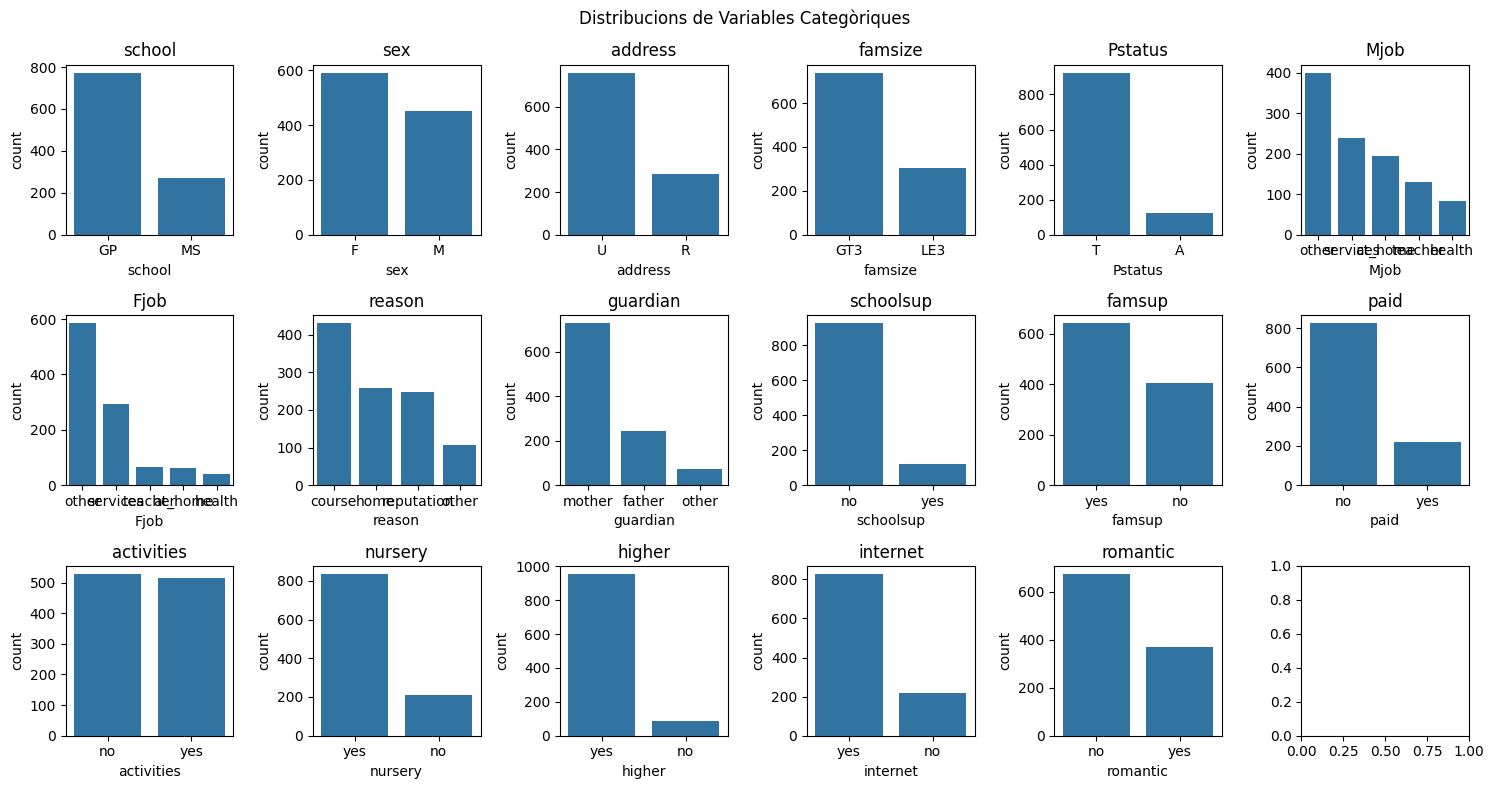

In [6]:
df_cat = df[categorics]
fig, axes = plt.subplots(3, 6, figsize=(15, 8))
fig.suptitle('Distribucions de Variables Categòriques')

for i, ax in enumerate(axes.ravel()):
    if i < df_cat.shape[1]:
        column_name = df_cat.columns[i]
        sns.barplot(x=df_cat[column_name].value_counts().index, y=df_cat[column_name].value_counts(), ax=ax)
        ax.set_ylabel('count')
        ax.set_title(column_name)

plt.tight_layout()
plt.show()

Balanceig targets.

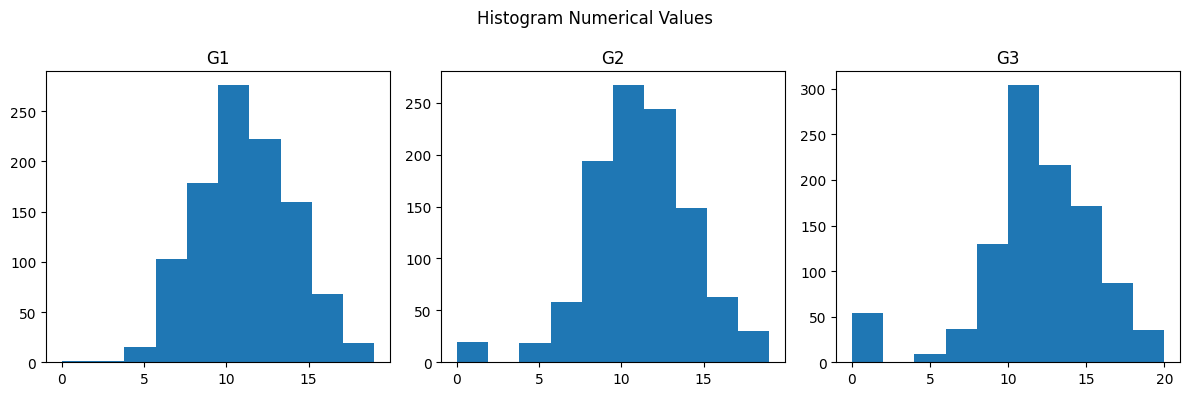

In [7]:
df_targ = df[targets]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
fig.suptitle('Histogram Numerical Values')

for i, ax in zip(df_targ.columns, axes.ravel()):
    ax.hist(df_targ[i], bins=10)
    ax.set_title(i)

plt.tight_layout()

Mirare la quantitat de 0 que hi ha en cada G ja que em pot fer sospitar que es degui a l'abandonament per part dels estudiants del curs al veures els G anteriors suspesos.

In [8]:
for target in targets:
    count_zeros = df[df[target] == 0].shape[0]
    print(f"Para el target '{target}' hay {count_zeros} valores '0'")

Para el target 'G1' hay 1 valores '0'
Para el target 'G2' hay 20 valores '0'
Para el target 'G3' hay 53 valores '0'


In [9]:
count_combinations = defaultdict(lambda: {'Aprobado': defaultdict(int), 'Suspendido': defaultdict(int)})

for index, row in df.iterrows():
    if any(row[target] == 0 for target in targets):
        for target in targets:
            if row[target] == 0:
                other_targets = [col for col in targets if col != target]
                for other_target in other_targets:
                    if row[other_target] > 9:
                        count_combinations[target]['Aprobado'][other_target] += 1
                    else:
                        count_combinations[target]['Suspendido'][other_target] += 1

# Mostrar el recuento de combinaciones para cada target que sea 0
print("Recuento de combinaciones para cada target que sea 0 dividido por otros targets:")
for target, counts in count_combinations.items():
    print(f"Para el target '{target}':")
    for key, value in counts.items():
        print(f"- {key}:")
        for other_target, count in value.items():
            print(f"   * {other_target}: {count}")


Recuento de combinaciones para cada target que sea 0 dividido por otros targets:
Para el target 'G3':
- Aprobado:
   * G1: 8
   * G2: 2
- Suspendido:
   * G1: 45
   * G2: 51
Para el target 'G2':
- Aprobado:
   * G1: 3
- Suspendido:
   * G3: 20
   * G1: 17
Para el target 'G1':
- Aprobado:
   * G2: 1
   * G3: 1
- Suspendido:


In [10]:
for target in targets:
    rows_with_zero = df[df[target] == 0]
    print(f"\nPara el target '{target}':")
    for index, row in rows_with_zero.iterrows():
        print(f"Valor '0' en '{target}', valor de 'absences': {row['absences']}")



Para el target 'G1':
Valor '0' en 'G1', valor de 'absences': 4

Para el target 'G2':
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0
Valor '0' en 'G2', valor de 'absences': 0

Para el target 'G3':
Valor '0' en 'G3', valor de 'absences': 0
Valor '0' 

### PROCESSING

#### FEATURE SELECTION

#### DECICIR QUIN DELS DOS

He decidit quedarme amb tots els atributs del dataset ja que trobo que tots tenen rellevància per al model, encara que alguns més que altres, i tot i tenir bastants atributs categòrics després de fer una primera exploració no veig que tingui cap problema per a codificar, ja que la majoria són binaris.

He decidit quedarme amb tots els atributs del dataset menys amb el atribut nursery ja que trobo que tots tenen rellevància per al model, encara que alguns més que altres, i tot i tenir bastants atributs categòrics després de fer una primera exploració no veig que tingui cap problema per a codificar, ja que la majoria són binaris.

In [11]:
#df = df.drop(['nursery'], axis=1)

#### NORMALITZACIO

El primer que farem serà normalitzar logaritmicament les dades per a que tingui una distribució normal el més semblant possible. Seguidament, escalarem les dades per a que vagin de 0 a 1 com a minim i màxim, amb el Min-Max Scaling.

La normalització logarítmica s'utilitza per transformar dades amb distribucions sesgades o una ampla variabilitat, reduint el sesgament i l'amplitud dels valors. Ajudar a igualar la distribució, estabilitzar la variància, facilitar la interpretació i preparar les dades per a certs models, però la seva aplicabilitat depèn de la naturalesa de les dades i del context del problema.

In [12]:
numerics_norm = [numeric + '_norm' for numeric in numerics]
for nums, nums_norm in zip(numerics, numerics_norm):
    df[nums_norm] = np.log1p(df[nums])

La funció principal del MinMaxScale és escalar les dades entre un rang específic, en aquest cas entre 0 i 1.  
El MinMaxScaler es una técnica de escalado que transforma los datos de tal manera que quedan en un rango específico, generalmente entre 0 y 1. Ens facilita la seva comparació ja que tots les variables categoriques tenen el mateix rang de dades.

In [13]:
scaler = MinMaxScaler()
df[numerics_norm] = scaler.fit_transform(df[numerics_norm])
df.isna().sum()

school             0
sex                0
age                0
address            0
famsize            0
Pstatus            0
Medu               0
Fedu               0
Mjob               0
Fjob               0
reason             0
guardian           0
traveltime         0
studytime          0
failures           0
schoolsup          0
famsup             0
paid               0
activities         0
nursery            0
higher             0
internet           0
romantic           0
famrel             0
freetime           0
goout              0
Dalc               0
Walc               0
health             0
absences           0
G1                 0
G2                 0
G3                 0
age_norm           0
Medu_norm          0
Fedu_norm          0
traveltime_norm    0
studytime_norm     0
failures_norm      0
famrel_norm        0
freetime_norm      0
goout_norm         0
Dalc_norm          0
Walc_norm          0
health_norm        0
absences_norm      0
dtype: int64

In [14]:
df = df.drop(numerics, axis=1)

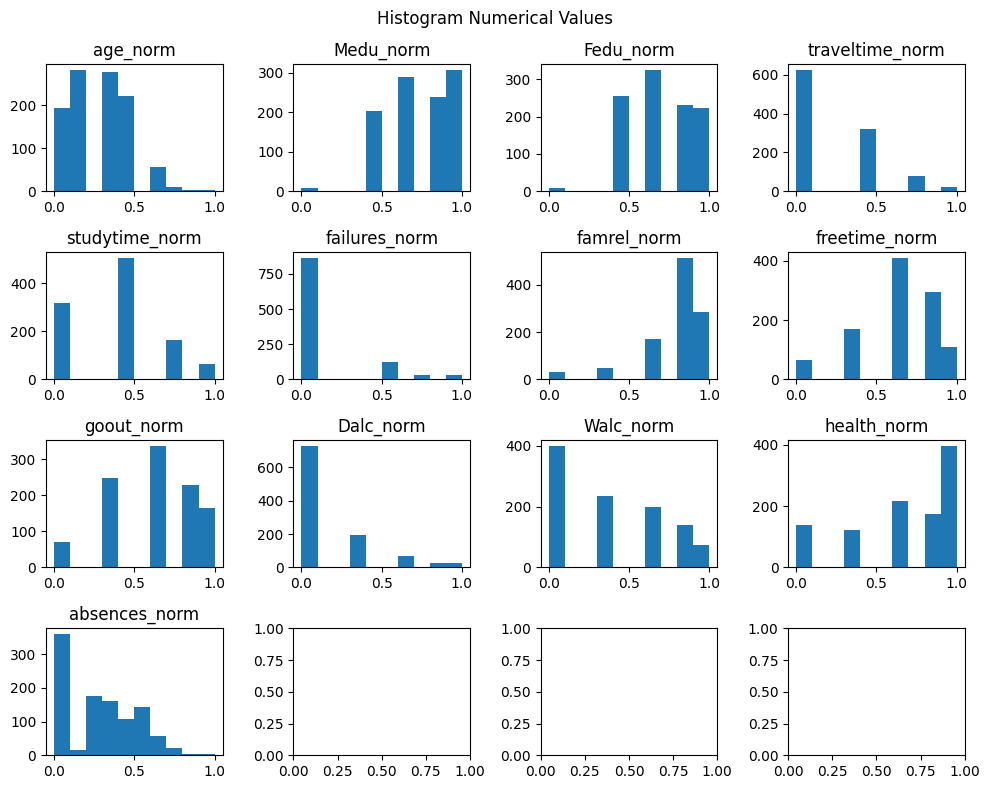

In [15]:
df_num = df[numerics_norm]
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 8))
fig.suptitle('Histogram Numerical Values')

for i, ax in zip(df_num.columns, axes.ravel()):
    ax.hist(df_num[i], bins=10)
    ax.set_title(i)

plt.tight_layout()

#### ENCODING

Per a aquest apartat he decidit fer dos tipus d'encoding. Fare sevir el LabelEncoder per als atributs binaris i el OneHotEncoding per als altre.  
Això ho faig perque el LabelEncoder pot, avegades, afegir un ordre intrinsic que no existeix realment en les dades del dataset i es per això que pels atributs que no son binaris he decidit fer servir el OneHotEncoder. One Hot Encoder ens afegeix una columna nova per cadascuna de les classes de la columna codificada i posa un 1 a la fila que correspon amb la categoria. Això fa que la dimensionalitat del dataset augmenti molt per això amb les binaries faré un LabelEncoder.

In [16]:
binary = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
non_binary = ['Mjob', 'Fjob', 'reason', 'guardian']

In [17]:
label_encoder = LabelEncoder()
for attr in binary:
    encoded_values = label_encoder.fit_transform(df[attr])
    df[attr] = encoded_values

In [18]:
for attr in non_binary:
    encoder = OneHotEncoder(sparse=False)
    attribute_encoded = encoder.fit_transform(df[[attr]])

    new_column_names = encoder.get_feature_names_out(input_features=[attr])
    encoded_df = pd.DataFrame(attribute_encoded, columns=new_column_names, index=df.index)

    df = df.drop([attr], axis=1)
    df = pd.concat([df, encoded_df], axis=1)

In [19]:
df.head()

,school,sex,address,famsize,Pstatus,schoolsup,famsup,paid,activities,nursery,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,0,0,1,0,0,1,0,0,0,1,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,0,1,0,1,0,1,0,0,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,0,1,1,1,1,0,1,0,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0,0,1,0,1,0,1,1,1,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0,0,1,0,1,0,1,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
def aprovado(fila):
    if fila['G1'] < 9:
        if fila['G2'] < 9:
            return 0
        if fila['G3'] < 9:
            return 0
    elif fila ['G2'] < 9:
        if fila['G1'] < 9:
            return 0
        if fila['G3'] < 9:
            return 0
    elif fila ['G3'] < 9:
        if fila['G1'] < 9:
            return 0
        if fila['G2'] < 9:
            return 0
    nota_final = (fila['G1'] + fila['G2'] + fila['G3']) / 3
    return 1 if nota_final > 9 else 0

# Crear la nueva columna 'aproved' aplicando la función a cada fila
df['approved'] = df.apply(aprovado, axis=1)

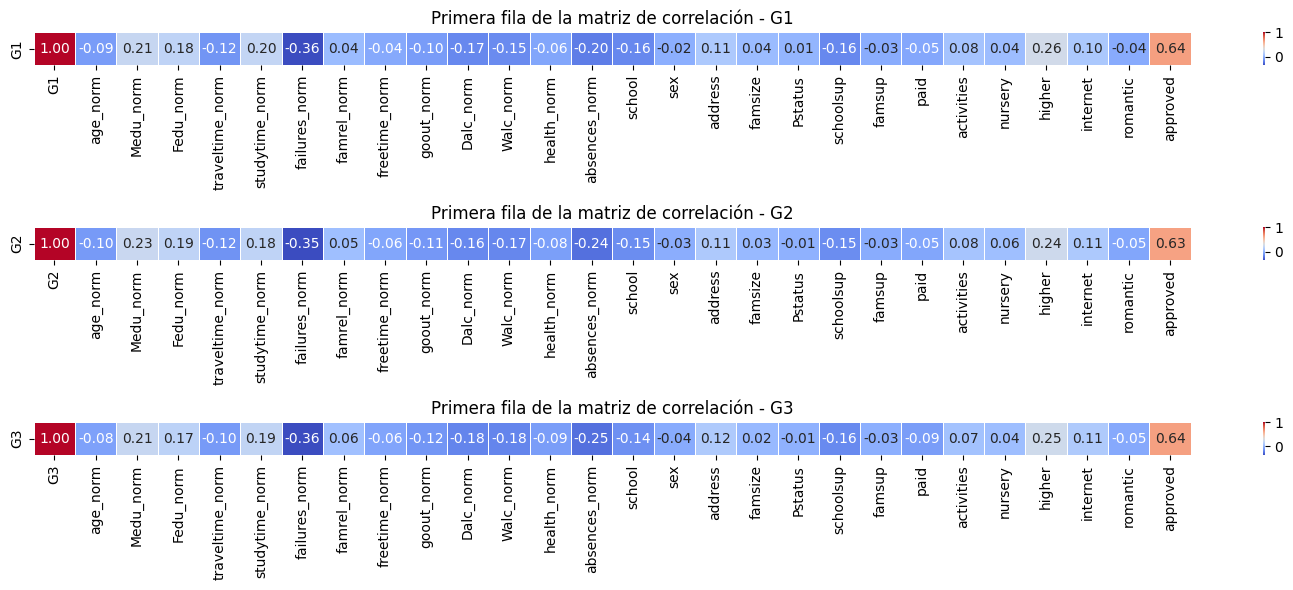

In [87]:
numericsG1 = numerics_norm.copy()
numericsG1.extend(binary.copy())
numericsG1.append('approved')
numericsG2 = numerics_norm.copy()
numericsG2.extend(binary.copy())
numericsG2.append('approved')
numericsG3 = numerics_norm.copy()
numericsG3.extend(binary.copy())
numericsG3.append('approved')

numericsG1.insert(0, 'G1')
numericsG2.insert(0, 'G2')
numericsG3.insert(0, 'G3')

# Calcular la matriz de correlación para G1
correlation_matrix_G1 = df[numericsG1].corr()
first_row_correlation_G1 = correlation_matrix_G1.iloc[[0]]

# Calcular la matriz de correlación para G2
correlation_matrix_G2 = df[numericsG2].corr()
first_row_correlation_G2 = correlation_matrix_G2.iloc[[0]]

# Calcular la matriz de correlación para G3
correlation_matrix_G3 = df[numericsG3].corr()
first_row_correlation_G3 = correlation_matrix_G3.iloc[[0]]

# Mostrar las primeras filas de las matrices de correlación para G1, G2 y G3 en filas separadas
plt.figure(figsize=(15, 6))

plt.subplot(3, 1, 1)
sns.heatmap(first_row_correlation_G1, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Primera fila de la matriz de correlación - G1')

plt.subplot(3, 1, 2)
sns.heatmap(first_row_correlation_G2, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Primera fila de la matriz de correlación - G2')

plt.subplot(3, 1, 3)
sns.heatmap(first_row_correlation_G3, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Primera fila de la matriz de correlación - G3')

plt.tight_layout()
plt.show()

### 3. MODEL SELECTION AMB CV

En aquest apartat entrenarem 6 models diferents de classificació. Aquests són: LogisticRegression, SVM, KNN, RandomForest, XGBoost i AdaBoost. La selecció d'aquests classificadors ha estat influenciada pel nostre coneixement actual sobre aquests models. Són models que hem estudiat i coneixem superficialment el seu funcionament. Els avaluarem segons la mètrica de f1-score per decidir quin és el millor.

Per entrenar-los farem servir el cross validation i, posteriorment, farem una cerca d'hiperparàmetres per a que els models puguin ser el mes precisos posible.

És important fer servir la validació creuada a l'entrenament dels models per evitar possibles Overfittings o Underfittings. Sobretot per que tractem amb un dataset desbalancejat, al qual una partició errònia al fer el entrenament ens portaria a resultats no desitjats. 

Una decisió important a la validació és la selecció d'un bon hyperparametre n_splits que és equivalent a la k. Un valor petit com 3 o 5 pot tenir un cost computacional bastant baix, però a la vegada pot provocar major variança i bias. En canvi, un valor alt com 10, encara que té més cost computacional, a canvi tindrà menys variança i bias, aixó doncs obtenim mesures més estables i representatives. 

Resumidament, aquest procediment ens proporciona una mesura del rendiment més que fiable de cada model ja que avalua el comportament del model amb diferents particions.  

Concretament farem servir el StratifiedK-Fold CV el qual divideix el dataset en k particions, assegurant-se que en cada partició es guardi la proporció d'exemples de cada clase del dataset original, entrenant el model amb les k particions i fent la mitja per a quedar-se amb el resultat final. El StratifiedK-Fold CV és més útil que el K-Fold CV quan les dades estan desbalancejades, que és el nostre cas, ja que assegura equitat a la distribució de les classes als subconjunts de dades.

In [21]:
def aprovado(fila):
    if fila['G1'] < 9:
        if fila['G2'] < 9:
            return 0
        if fila['G3'] < 9:
            return 0
    elif fila ['G2'] < 9:
        if fila['G1'] < 9:
            return 0
        if fila['G3'] < 9:
            return 0
    elif fila ['G3'] < 9:
        if fila['G1'] < 9:
            return 0
        if fila['G2'] < 9:
            return 0
    nota_final = (fila['G1'] + fila['G2'] + fila['G3']) / 3
    return 1 if nota_final > 9 else 0

# Crear la nueva columna 'aproved' aplicando la función a cada fila
df['approved'] = df.apply(aprovado, axis=1)

<Axes: >

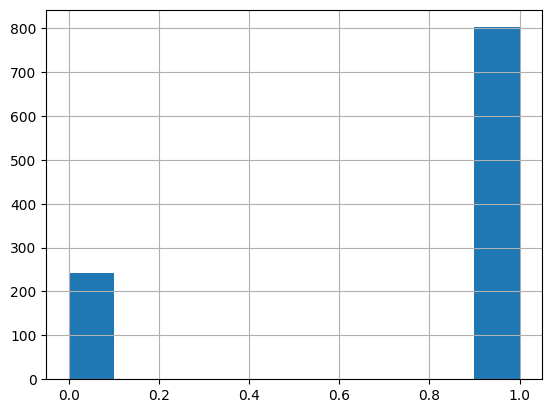

In [22]:
df['approved'].hist()

In [23]:
df

,school,sex,address,famsize,Pstatus,schoolsup,famsup,paid,activities,nursery,...,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,approved
0,0,0,1,0,0,1,0,0,0,1,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0,0,1,0,1,0,1,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,0,0,1,1,1,1,0,1,0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
3,0,0,1,0,1,0,1,1,1,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
4,0,0,1,0,1,0,1,1,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,1,0,0,0,1,0,0,0,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1040,1,0,1,1,1,0,1,0,0,1,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1041,1,0,1,0,1,0,0,0,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1042,1,1,1,1,1,0,0,0,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1


In [92]:
positive_correlation = first_row_correlation_G1[first_row_correlation_G1 > 0].dropna(axis=1)

# Obtener los nombres de los atributos con correlaciones positivas
attributes_with_positive_corr = positive_correlation.columns.tolist()

In [93]:
attributes_with_positive_corr = attributes_with_positive_corr[1:]
attributes_with_positive_corr.extend(['Dalc_norm', 'Walc_norm', 'approved'])
attributes_with_positive_corr

['Medu_norm',
 'Fedu_norm',
 'studytime_norm',
 'famrel_norm',
 'address',
 'famsize',
 'Pstatus',
 'activities',
 'nursery',
 'higher',
 'internet',
 'approved',
 'Dalc_norm',
 'Walc_norm',
 'approved']

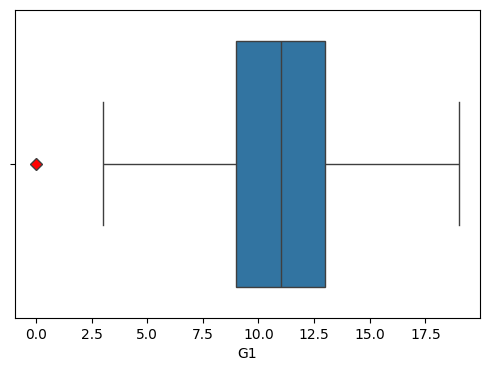

In [26]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['G1'], flierprops=dict(markerfacecolor='r', marker='D'))
plt.show()

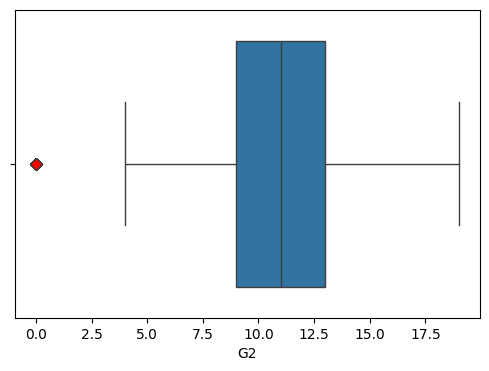

In [27]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['G2'], flierprops=dict(markerfacecolor='r', marker='D'))
plt.show()

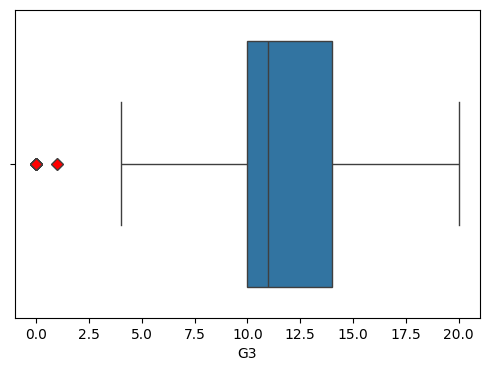

In [28]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['G3'], flierprops=dict(markerfacecolor='r', marker='D'))
plt.show()

In [29]:
from scipy import stats

# Supongamos que 'df' es tu DataFrame y 'G3' es la columna de interés
outliers = df['G3']

# Calcular el rango intercuartílico para detectar outliers
Q1 = np.percentile(outliers, 25)
Q3 = np.percentile(outliers, 75)
IQR = Q3 - Q1

# Calcular los límites para los valores atípicos
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Obtener los índices de las filas que son consideradas valores atípicos
outliers_indices_G3 = df[(df['G3'] < lower_bound) | (df['G3'] > upper_bound)].index

# Mostrar los índices de los outliers
print(outliers_indices_G3)

Index([ 128,  130,  131,  134,  135,  136,  137,  140,  144,  146,  148,  150,
        153,  160,  162,  168,  170,  173,  221,  239,  242,  244,  259,  264,
        269,  296,  310,  316,  332,  333,  334,  337,  341,  343,  367,  383,
        387,  389,  558,  567,  835,  914,  958,  962,  978,  981,  992,  998,
       1000, 1005, 1021, 1032, 1034, 1035],
      dtype='int64')


In [30]:
from scipy import stats

# Supongamos que 'df' es tu DataFrame y 'G3' es la columna de interés
outliers = df['G2']

# Calcular el rango intercuartílico para detectar outliers
Q1 = np.percentile(outliers, 25)
Q3 = np.percentile(outliers, 75)
IQR = Q3 - Q1

# Calcular los límites para los valores atípicos
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Obtener los índices de las filas que son consideradas valores atípicos
outliers_indices_G2 = df[(df['G2'] < lower_bound) | (df['G2'] > upper_bound)].index

# Mostrar los índices de los outliers
print(outliers_indices_G2)

Index([ 130,  131,  134,  135,  136,  137,  144,  153,  162,  242,  244,  269,
        332,  835,  958,  962,  992,  998, 1000, 1005],
      dtype='int64')


In [31]:
from scipy import stats

# Supongamos que 'df' es tu DataFrame y 'G3' es la columna de interés
outliers = df['G1']

# Calcular el rango intercuartílico para detectar outliers
Q1 = np.percentile(outliers, 25)
Q3 = np.percentile(outliers, 75)
IQR = Q3 - Q1

# Calcular los límites para los valores atípicos
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Obtener los índices de las filas que son consideradas valores atípicos
outliers_indices_G1 = df[(df['G1'] < lower_bound) | (df['G1'] > upper_bound)].index

# Mostrar los índices de los outliers
print(outliers_indices_G1)

Index([395], dtype='int64')


TREURE OUTLIERS

In [32]:
df = df.drop(outliers_indices_G3, axis=0)

<Axes: >

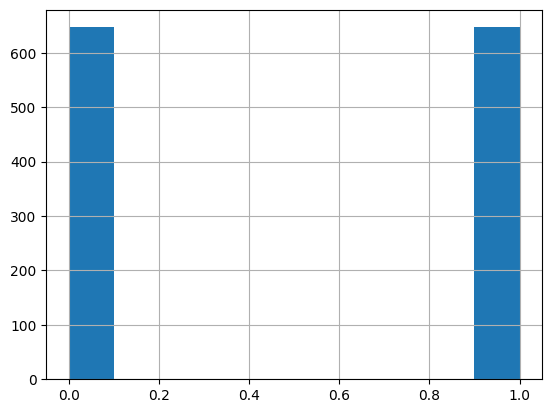

In [61]:
X = df.drop(['approved', 'G1', 'G2', 'G3'], axis=1)
#X = df[attributes_with_positive_corr]
#X = df[['Dalc_norm', 'Walc_norm']]
y = df['approved']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#ro = RandomOverSampler(sampling_strategy='auto', random_state=42)
ro = SMOTE(sampling_strategy='auto', random_state=42)

X_train, y_train = ro.fit_resample(X_train, y_train)

y_train.hist()

              precision    recall  f1-score   support

           0       0.28      0.53      0.37        43
           1       0.83      0.61      0.70       155

    accuracy                           0.60       198
   macro avg       0.55      0.57      0.53       198
weighted avg       0.71      0.60      0.63       198
 0.5738934733683421


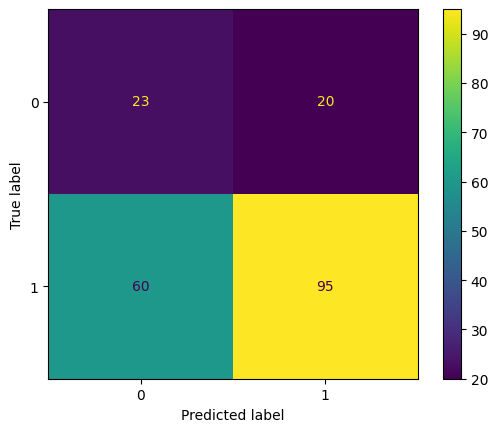

In [69]:
RF = KNeighborsClassifier()
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
mse = classification_report(y_test, y_pred)
ba = balanced_accuracy_score(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print(mse, ba)

In [102]:
X = df.drop(['G3'], axis=1)
#X = df[['Medu_norm', 'Fedu_norm', 'studytime_norm', 'approved']]
# attributes_with_positive_corr.append('G1')
# attributes_with_positive_corr.append('G2')
#X = df[attributes_with_positive_corr]
y = df['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

RF = GradientBoostingRegressor()
#RF.classes_ = y.unique()
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R2 Score:", r2)

Mean Squared Error: 0.8374931924455687
R2 Score: 0.8946874499094324


In [ ]:
X = df[['G2']]
#X = df[attributes_with_positive_corr]
y = df['G3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=7)  # Selecciona el grado polinómico
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)

y_pred = model.predict(X_test_poly)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R2 Score:", r2)

Mean Squared Error: 0.8924213394987024
R2 Score: 0.8877803809444615


In [99]:
f1_scores = {'Sense hyperparametres': {'SVM': 0, 'LR': 0, 'RF': 0, 'XGB': 0,}, 'Amb hyperparametres': {'KNN': 0, 'SVM': 0, 'LR': 0, 'RF': 0, 'XGB': 0, 'ADA': 0}}

classifiers = {'RF': RandomForestClassifier(), 'XGB': XGBClassifier(), 'SVM': SVC(), 'LR': LogisticRegression(), 'KNN' : KNeighborsClassifier(), 'ADA': AdaBoostClassifier()}

stratified_kfold = KFold(n_splits=5, shuffle=True, random_state=42)

X = df.drop(['approved', 'G1', 'G2', 'G3'], axis=1)
y = df['approved']

def avaluacio_models_k_fold(model, stratified_kfold, f1_scores, model_name):
    y_preds = []
    y_tests = []
    f1_acc = []
    acc_acc = []
    bal_acc = []
    for i, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        ro = SMOTE(sampling_strategy='auto', random_state=42)

        X_train, y_train = ro.fit_resample(X_train, y_train)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='macro')
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_balanced = balanced_accuracy_score(y_test, y_pred)
        f1_acc.append(f1)
        acc_acc.append(accuracy)
        y_preds.extend(y_pred)
        y_tests.extend(y_test)
        bal_acc.append(accuracy_balanced)
    scores = {'f1_macro' : np.array(f1_acc).mean(), 'accuracy' : np.array(acc_acc).mean(), 'accuracy balanced' : np.array(bal_acc).mean()}
    f1_scores['Sense hyperparametres'][model_name] = scores
    print(classification_report(y_preds, y_tests))

for model_name, model in classifiers.items():
    avaluacio_models_k_fold(model, stratified_kfold, f1_scores, model_name)

              precision    recall  f1-score   support

           0       0.34      0.47      0.40       136
           1       0.91      0.85      0.88       854

    accuracy                           0.80       990
   macro avg       0.63      0.66      0.64       990
weighted avg       0.83      0.80      0.81       990

              precision    recall  f1-score   support

           0       0.35      0.46      0.40       143
           1       0.90      0.86      0.88       847

    accuracy                           0.80       990
   macro avg       0.63      0.66      0.64       990
weighted avg       0.82      0.80      0.81       990

              precision    recall  f1-score   support

           0       0.41      0.40      0.41       192
           1       0.86      0.86      0.86       798

    accuracy                           0.77       990
   macro avg       0.63      0.63      0.63       990
weighted avg       0.77      0.77      0.77       990

              preci

In [100]:
f1_scores

{'Sense hyperparametres': {'SVM': {'f1_macro': 0.6299026505126772,
   'accuracy': 0.7717171717171717,
   'accuracy balanced': 0.6311119791042095},
  'LR': {'f1_macro': 0.6293512810113848,
   'accuracy': 0.7363636363636364,
   'accuracy balanced': 0.657950672331719},
  'RF': {'f1_macro': 0.6355748961198694,
   'accuracy': 0.8020202020202021,
   'accuracy balanced': 0.6229255412401453},
  'XGB': {'f1_macro': 0.6370464599237916,
   'accuracy': 0.7989898989898989,
   'accuracy balanced': 0.6273458541267821},
  'KNN': {'f1_macro': 0.5349137673454502,
   'accuracy': 0.6171717171717171,
   'accuracy balanced': 0.5795227742402796},
  'ADA': {'f1_macro': 0.6419684466724718,
   'accuracy': 0.7848484848484848,
   'accuracy balanced': 0.6410331002463983}},
 'Amb hyperparametres': {'KNN': 0,
  'SVM': 0,
  'LR': 0,
  'RF': 0,
  'XGB': 0,
  'ADA': 0}}

#### Cerca d'hyperparametres

Escollir els paràmetres idonis per entrenar el model pot ser una tasca tediosa. Existeixen per això tècniques que et troben la millor combinació d'hyperparametres possible. Aquests són alguns com GridSearchCV, RandomizedSearchCV o HalvingRandomSearchCV.

En termes de cost computacional, podem dir que la primera és la més costosa per la seva exhaustivitat al provar cada combinació possible. Les dues altres opcions, molt menys costoses, poden resultar més eficients en segons que aspectes, però hem de tenir en compte que necessitem la millor combinació possible de hyperparametres. Així doncs, escollim la exhaustivitat del GridSearch respecte la eficiència del RandomizedSearch.

Per analisis encara més profunds, podriem parlar de tècniques de cerca encara més eficients. Aquestes les podem extreure de llibrerias com scikit-optimize. Un possible exemple seria l'optimització Bayesiana. Aquesta modela la funció objectiu i fa la cerca en funció del rendiment, sempre tractant de maximitzar-lo. Altre mètode d'optimització és Tunning, on bàsicament es fa una optimització de hyperparametres per afinar encara més el rendiment en un conjunt de dades específic. No confondre amb el fine-tunning, que no ajusta hyperparametres si no un model entrenat previament.

In [ ]:
# def grid_search(model, param_grid, X, y, cv):
#     start_time = time.time()
#     grid_search = GridSearchCV(model, param_grid=param_grid, scoring='f1_macro', cv=cv, verbose=True, n_jobs=-1)
#     end_time = time.time()
#     duration = end_time - start_time
#     grid_search.fit(X, y)
#     best_model = grid_search.best_estimator_
#     y_pred = best_model.predict(X)
#     accuracy = accuracy_score(y, y_pred)
#     best_params = grid_search.best_params_
#     best_score = grid_search.best_score_
#     print(best_params, best_score)
#     scores = {'f1_macro' : best_score, 'accuracy' : accuracy}
#     return scores, best_params, y_pred, duration


# param_grids = {
#     'RF': {
#         'n_estimators': [400,450,500,550],
#         'criterion':['gini','entropy'],
#         'bootstrap': [True],
#         #'max_depth': [15, 20, 25],
#         'max_features': ['auto','sqrt'],
#         #'min_samples_leaf': [2,3],
#         #'min_samples_split': [2,3],
#         'random_state': [None, 42]
#     },
#     'XGB': {
#         'n_estimators': [450,500,550],
#         'colsample_bytree': [0.75,0.9],
#         'max_depth': [None, 5, 15],
#         'reg_alpha': [1, 2],
#         #'reg_lambda': [2, 5],
#         'subsample': [0.55, .65],
#         #'learning_rate':[0.5, 0.1],
#         'gamma':[.5,1],
#         #'min_child_weight':[0.01, 0.1],
#         'sampling_method': ['uniform', 'gradient_based']
#     },
#     'KNN' :
#     {'n_neighbors' : [3,5,7,9,12],
#               'weights' : ['uniform', 'distance'],
#               'algorithm' : ['auto', 'ball_tree','kd_tree', 'brute'],
#               'p' : [1,2,3],
#               'leaf_size': [10, 30, 50, 60],
#               'metric': ['euclidean', 'manhattan', 'minkowski']},
#     'SVM': [
#         {'kernel': ['rbf'], 'gamma': [.1,.5,1,2, 5], 'C': [.1, 1, 10, 100, 1000]},
#         {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
#         {'kernel': ['poly'], 'degree' : [2,3,4], 'C': [.1, 1, 10, 100]}
#     ],
#     'LR': {
#         'max_iter' : [1000, 2000],
#         'penalty' : ['l1', 'l2', 'elasticnet'],
#         'C' : np.logspace(-4, 4, 20),
#         'solver' : ['liblinear',  'saga'],
#         'l1_ratio': [0.1, 0.5, 0.9]
#     },
#     'ADA': {
#         'n_estimators': [50, 100, 200, 300],  
#         'learning_rate': [0.01, 0.1, 1.0, 2.0],  
#         'base_estimator': [None], 
#         'algorithm': ['SAMME', 'SAMME.R'],
#         'random_state': [None, 42, 100],
#     }
# }

# results = []
# y_preds = []
# for classifier_name, classifier in classifiers.items():
#     params = param_grids[classifier_name]
#     best_score, best_params, preds, duration = grid_search(classifier, params, X, y, stratified_kfold)
#     results.append({
#         'Model': classifier_name,
#         'Millors Parametres': best_params,
#         'Millor Scores': best_score,
#         'Time' : duration
#     })
#     f1_scores['Amb hyperparametres'][classifier_name] = best_score
#     y_preds.append(preds)
#     print(f1_scores)

In [ ]:
# results_2 = []
# for result in results:
#     results_2.append({
#         'Model': result['Model'],
#         #'Millors Parametres': result['Millors Parametres'],
#         'Millor Scores F1': result['Millor Scores']['f1_macro'],
#         'Millor Scores Accuracy': result['Millor Scores']['accuracy'],
#         'Time': result['Time']
#     })

# df = pd.DataFrame(results_2)
# df